# 1. Exoplanet characterisation based on a single light curve

## Introduction

This is a first part of a set of tutorials covering Bayesian exoplanet characterisation using wide-band photometry (transit light curves), radial velocities, and, later, transmission spectroscopy. The tutorials use freely available open source tools built around the scientific python ecosystem, and also demonstrate the use of ``PyTransit`` and ``LDTk``.

The tutorials are mainly targeted to graduate students working in exoplanet characterisation who already have some experience of Python and Bayesian statistics. 

## Prerequisites

This tutorial requires the basic Python packages for scientific computing and data analysis
- NumPy, SciPy, IPython, astropy, pandas, matplotlib, and [seaborn](http://stanford.edu/~mwaskom/software/seaborn/)

The MCMC sampling requires the [*emcee*](https://github.com/dfm/emcee) and [acor](https://github.com/dfm/acor) packages by D. Foreman-Mackey. These can either be installed from github or from [PyPI](https://pypi.python.org/pypi).

The transit modelling is carried out with [PyTransit](https://github.com/hpparvi/PyTransit),  and global optimisation with [PyDE](https://github.com/hpparvi/PyDE). These three can be installed easily from github. First ``cd`` into the directory you want to clone the code, and then

    git clone https://github.com/hpparvi/PyDE.git; cd PyDE    
    python setup.py config_fc --fcompiler=gnu95 --opt="-Ofast" --f90flags="-cpp -fopenmp" build
    python setup.py install --user; cd -

    git clone https://github.com/hpparvi/PyTransit.git; cd PyTransit
    python setup.py config_fc --fcompiler=gnu95 --opt="-Ofast" --f90flags="-cpp -fopenmp" build
    python setup.py install --user; cd -
    
Assuming you have GFortran as your default Fortran compiler and have GCC >= 4.8. If not, you may need to change the ``-Ofast`` optimization flag to ``-O3``.

What comes to assumed prior knowledge, well... I assume you already know a bit about Bayesian statistics (I'll start with a very rough overview of the basics of Bayesian parameter estimation, though), Python (and especially the scientific packages), have a rough idea of MCMC sampling (and how *emcee* works), and, especially, have the grasp of basic concepts of exoplanets, transits, and photometry.

## Bayesian parameter estimation

This first tutorial covers the simple case of an exoplanet system characterisation based on a single photometric timeseries of an exoplanet transit (transit light curve). The system characterisation is a *parameter estimation* problem, where we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [*Bayesian*](http://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [*posterior probability*](http://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [*prior probabilities*](http://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the [*Bayes' theorem*](http://en.wikipedia.org/wiki/Bayes%27_theorem) as

$$
P(\theta|D) = \frac{P(\theta) P(D|\theta)}{P(D)}, \qquad P(D|\theta) = \prod P(D_i|\theta),
$$

where $P(\theta)$ is the prior, $P(D|\theta)$ is the [*likelihood*](http://en.wikipedia.org/wiki/Likelihood_function) for the data, and $P(D)$ is a [*normalising factor*](http://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC-based parameter estimation. 

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log P(\theta|D) = \log P(\theta) + \log P(D|\theta),  \qquad \log P(D|\theta) = \sum \log P(D_i|\theta)
$$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function

$$
 \log P(D|\theta) = -N\log(\sigma) -\frac{N\log 2\pi}{2} - \sum_{i=0}^N \frac{(o_i-m_i)^2}{2\sigma^2},
$$

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model. 

*Note:* Unfortunately, the noise is rarely white, but contains systematic components from instrumental and astrophysical sources that should be accounted for by the noise model for robust parameter estimation. This, however, goes beyond a basic tutorial.

## Implementation

### Initialisation

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math as mt
import pandas as pd
import seaborn as sb

with warnings.catch_warnings():
    cp = sb.color_palette()

from pathlib import Path
from IPython.display import display, HTML
from numba import njit
from astropy.io import fits as pf
from emcee import EnsembleSampler
from tqdm import tqdm
from corner import corner
from scipy.constants import G

from pyde import DiffEvol
from pytransit.orbits_f import orbits as of
from pytransit import MandelAgol as MA
from pytransit.param.parameter import (ParameterSet, GParameter, PParameter, LParameter,
                                       NormalPrior as NP, 
                                       UniformPrior as UP)

random.seed(0)

In [3]:
d_h = 24.
d_m = 60 * d_h
d_s = 60 * d_m

@njit("f8(f8[:], f8[:], f8)")
def ll_normal_es(o,m,e):
    """Normal log likelihood for scalar average standard deviation."""
    return -o.size*log(e) -0.5*o.size*log(2*pi) - 0.5*square(o-m).sum()/e**2

@njit
def as_from_rhop(rho, period):
    """Scaled semi-major axis from the stellar density and planet's orbital period.

    Parameters
    ----------

      rho    : stellar density [g/cm^3]
      period : orbital period  [d]

    Returns
    -------

      as : scaled semi-major axis [R_star]
    """
    return (G/(3.*pi))**(1./3.)*((period*d_s)**2 * 1e3*rho)**(1./3.)


### Log posterior function

The log posterior function is the workhorse of the analysis. I implement it as a class that stores the observation data and the priors, contains the methods to calculate the model and evaluate the log posterior probability density, and encapsulates the optimisation and MCMC sampling routines.

In [4]:
class LPFunction(object):
    """A basic log posterior function class.
    """
    def __init__(self, time, flux, nthreads=1):
        
        # Set up the transit model
        # ------------------------
        self.tm = MA(interpolate=True, klims=(0.08,0.13), nthr=nthreads) 
        self.nthr = nthreads

        # Initialise data
        # ---------------
        self.time     = time.copy() if time is not None else array([])
        self.flux_o   = flux.copy() if flux is not None else array([])
        self.npt      = self.time.size
        
        # Set the optimiser and the MCMC sampler
        # --------------------------------------
        self.de = None
        self.sampler = None
        
        # Set up the parametrisation and priors
        # -------------------------------------
        psystem = [
            GParameter('tc',  'zero_epoch',       'd',      NP(1.01, 0.02), (-inf, inf)),
            GParameter('pr',  'period',           'd',      NP(2.50, 1e-7), (   0, inf)),
            GParameter('rho', 'stellar_density',  'g/cm^3', UP(0.90, 2.50), (0.90, 2.5)),
            GParameter('b',   'impact_parameter', 'R_s',    UP(0.00, 1.00), (0.00, 1.0)),
            GParameter('k2',  'area_ratio',       'A_s',    UP(0.08**2, 0.13**2), (1e-8, inf))]
       
        pld = [
            PParameter('q1', 'q1_coefficient', '', UP(0, 1), bounds=(0, 1)),
            PParameter('q2', 'q2_coefficient', '', UP(0, 1), bounds=(0, 1))]
    
        pbl = [LParameter('es', 'white_noise', '', UP(1e-6, 1), bounds=(1e-6, 1))]
        per = [LParameter('bl', 'baseline',    '', NP(1.00, 0.001), bounds=(0.8, 1.2))]
        
        self.ps = ParameterSet()
        self.ps.add_global_block('system', psystem)
        self.ps.add_passband_block('ldc', 2, 1, pld)
        self.ps.add_lightcurve_block('baseline', 1, 1, pbl)
        self.ps.add_lightcurve_block('error', 1, 1, per)
        self.ps.freeze()    
        
        
    def compute_baseline(self, pv):
        """Constant baseline model"""
        return full_like(self.flux_o, pv[8])

    
    def compute_transit(self, pv):
        """Transit model"""
        _a  = as_from_rhop(pv[2], pv[1])  # Scaled semi-major axis from stellar density and orbital period
        _i  = mt.acos(pv[3]/_a)           # Inclination from impact parameter and semi-major axis
        _k  = mt.sqrt(pv[4])              # Radius ratio from area ratio
        
        a,b = mt.sqrt(pv[5]), 2*pv[6]
        _uv = array([a*b, a*(1.-b)])      # Quadratic limb darkening coefficients
        
        return self.tm.evaluate(self.time, _k, _uv, pv[0], pv[1], _a, _i)

    
    def compute_lc_model(self, pv):
        """Combined baseline and transit model"""
        return self.compute_baseline(pv) * self.compute_transit(pv)

    
    def lnprior(self, pv):
        """Log prior"""
        if any(pv < self.ps.lbounds) or any(pv>self.ps.ubounds):
            return -inf
        else:
            return self.ps.lnprior(pv)
    
    def lnlikelihood(self, pv):
        """Log likelihood"""
        flux_m = self.compute_lc_model(pv)
        return ll_normal_es(self.flux_o, flux_m, pv[7])
    
    
    def lnposterior(self, pv):
        """Log posterior"""
        lnprior = self.lnprior(pv)
        if isinf(lnprior):
            return lnprior
        else:
            return lnprior + self.lnlikelihood(pv)
        
        
    def create_pv_population(self, npop=50):
        return self.ps.sample_from_prior(npop)
        
        
    def optimize(self, niter=200, npop=50, population=None, label='Optimisation'):
        """Global optimisation using Differential evolution"""
        if self.de is None:
            self.de = DiffEvol(self.lnposterior, clip(self.ps.bounds, -1, 1), npop, maximize=True)
            if population is None:
                self.de._population[:, :] = self.create_pv_population(npop)
            else:
                self.de._population[:,:] = population
        for _ in tqdm(self.de(niter), total=niter, desc=label):
            pass

        
    def sample(self, niter=500, thin=5, label='MCMC sampling', reset=False):
        """MCMC sampling using emcee"""
        if self.sampler is None:
            self.sampler = EnsembleSampler(self.de.n_pop, self.de.n_par, self.lnposterior)
            pop0 = self.de.population
        else:
            pop0 = self.sampler.chain[:,-1,:].copy()
        if reset:
            self.sampler.reset()
        for _ in tqdm(self.sampler.sample(pop0, iterations=niter, thin=thin), total=niter, desc=label):
            pass

#### Priors

The priors are contained in a ``ParameterSet`` object from ``pytransit.param.parameter``. ``ParameterSet`` is a utility class containing a function for calculating the joint prior, etc. We're using only two basic priors: a normal prior ``NP``, for which $x \sim N(\mu,\sigma)$, a uniform prior ``UP``, for which $x \sim U(a,b)$.

We could use an informative prior on the planet-star area ratio (squared radius ratio) that we base on the observed NIR transit depth (see below). This is justified since the limb darkening, which affects the observed transit depth, is sufficiently weak in NIR. We would either need to use significantly wider informative prior, or an uninformative one, if we didn't have NIR data.

#### Model

The model has two components: a multiplicative constant baseline, and a transit shape modelled using the quadratic Mandel&nbsp;&&nbsp;Agol transit model implemented in ``PyTransit``. The sampling parameterisation is different than the parameterisation used by the transit model, so we need to map the parameters from the sampling space to the model space. Also, we're keeping things simple and assuming a circular orbit. Eccentric orbits will be considered in later tutorials.  

#### Limb darkening

The **limb darkening** uses the parameterisation by [Kipping (2013, MNRAS, 435(3), 2152–2160)](http://mnras.oxfordjournals.org/content/435/3/2152), where the quadratic limb darkening coefficients $u$ and $v$ are mapped from sampling parameters $q_1$ and $q_2$ as

$$
u = 2\sqrt{q_1}q_2,
$$

$$
v = \sqrt{q_1}(1-2q_2).
$$

This parameterisation allows us to use uniform priors from 0 to 1 to cover the whole physically sensible $(u,v)$-space.

#### Log likelihood

The *log likelihood* calculation is carried out by the ``ll_normal_es`` function that evaluates the normal log likelihood given a single error value.

### Read in the data

First we need to read in the (mock) observation data stored in ``obs_data.fits``. The data corresponds to a single transit observed simultaneously in eight passbands (filters). The photometry is saved in extension 1 as a binary table, and we want to read the mid-exposure times and flux values corresponding to different passbands. The time is stored in the ``time`` column, and fluxes are stored in the ``f_wn_*`` columns, where ``*`` is the filter name.

In [5]:
dfile = Path('data').joinpath('obs_data.fits')
data = pf.getdata(dfile, ext=1)

flux_keys = [n for n in data.names if 'f_wn' in n]
filter_names = [k.split('_')[-1] for k in flux_keys]

time = data['time'].astype('d')
fluxes = [data[k].astype('d') for k in flux_keys]

print ('Filter names: ' + ', '.join(filter_names))

Filter names: u, g, r, i, z, J2, H2, Ks


First, let's have a quick look at our data, and plot the blue- and redmost passbands. 

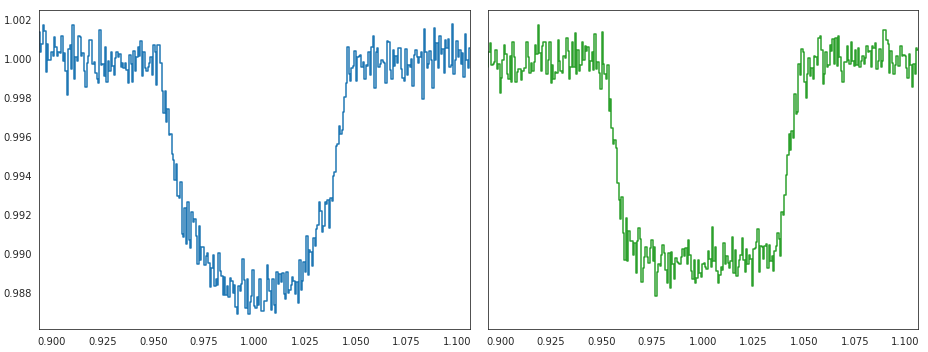

In [6]:
with sb.axes_style('white'):
    fig, axs = subplots(1,2, figsize=(13,5), sharey=True)
    axs[0].plot(time,fluxes[0], drawstyle='steps-mid', c=cp[0])
    axs[1].plot(time,fluxes[-1], drawstyle='steps-mid', c=cp[2])
    setp(axs, xlim=time[[0,-1]])
    fig.tight_layout()

Here we see what we'd expect to see. The stronger limb darkening in blue makes the bluemost transit round, while we can spot the end of ingress and the beginning of egress directly by eye from the redmost light curve. Also, the transit is deeper in *u'* than in *Ks*, which tells that the impact parameter *b* is smallish (the transit would be deeper in red than in blue for large *b*).

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

In [7]:
npop, de_iter, mc_burn, mc_iter, thin = 100, 200, 500, 1500, 10
lpf = LPFunction(time, fluxes[-1])

In [8]:
lpf.optimize(de_iter, npop)

Optimisation: 100%|██████████| 200/200 [00:02<00:00, 89.45it/s]


In [9]:
lpf.sample(mc_burn, thin=thin, label='MCMC warm up')
lpf.sample(mc_iter, thin=thin, reset=True, label='MCMC sampling')

MCMC sampling: 100%|██████████| 1500/1500 [00:14<00:00, 100.39it/s]


### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

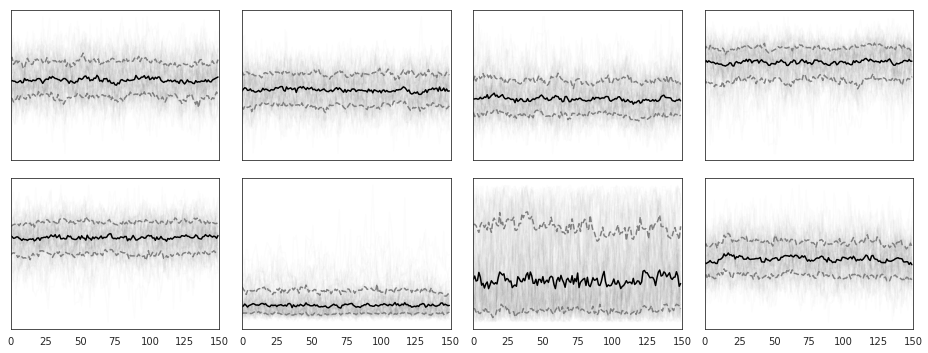

In [10]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
    [axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
    setp(axs, yticks=[], xlim=[0,mc_iter//10])
    fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [11]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [12]:
flux_pr = array([lpf.compute_lc_model(pv) for pv in fc[permutation(fc.shape[0])[:1000]]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

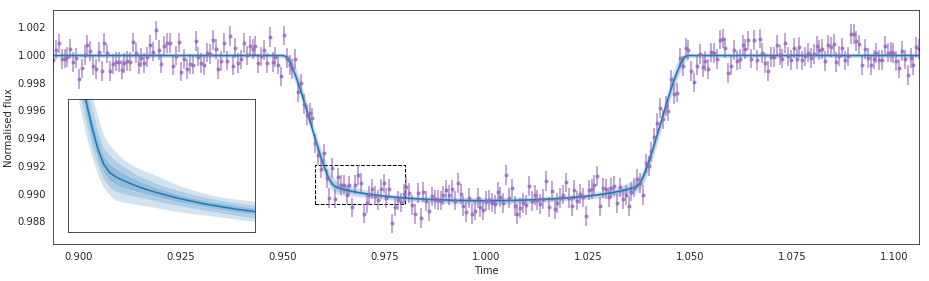

In [13]:
with sb.axes_style('white'):
    zx1,zx2,zy1,zy2 = 0.958,0.98, 0.9892, 0.992
    fig, ax = subplots(1,1, figsize=(13,4))
    cp = sb.color_palette()
    ax.errorbar(lpf.time, lpf.flux_o, mp[7], fmt='.', c=cp[4], alpha=0.75)
    [ax.fill_between(lpf.time,*flux_pc[i:i+2,:],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    ax.plot(lpf.time, flux_pc[0], c=cp[0])
    setp(ax, xlim=lpf.time[[0,-1]], xlabel='Time', ylabel='Normalised flux')
    fig.tight_layout()
    
    az = fig.add_axes([0.075,0.18,0.20,0.46])
    ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
    [az.fill_between(lpf.time,*flux_pc[i:i+2,:],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
    az.plot(lpf.time, flux_pc[0], c=cp[0])

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [14]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=lpf.ps.names)
df['es'] *= 1e6
df['k'] = sqrt(df.k2)
df['u'] = 2*sqrt(df.q1)*df.q2
df['v'] = sqrt(df.q1)*(1-2*df.q2)
df = df.drop('k2', axis=1)
df.describe()
#df.to_pickle(join('results','t1_df1.pkl'))

,tc,pr,rho,b,q1,q2,es,bl,k,u,v
count,15000.0000,1.5000e+04,15000.0000,15000.0000,15000.0000,1.5000e+04,15000.0000,1.5000e+04,15000.0000,1.5000e+04,15000.0000
mean,0.9999,2.5000e+00,1.4855,0.5130,0.0666,3.6524e-01,709.5367,9.9991e-01,0.1001,1.5088e-01,0.0941
std,0.0001,1.0242e-07,0.1356,0.0492,0.0447,2.7369e-01,28.9167,5.5806e-05,0.0007,9.6029e-02,0.1464
min,0.9992,2.5000e+00,1.0588,0.2556,0.0005,2.3356e-05,604.9250,9.9965e-01,0.0963,1.5044e-05,-0.2364
25%,0.9998,2.5000e+00,1.3890,0.4835,0.0346,1.3109e-01,689.5333,9.9987e-01,0.0996,7.1166e-02,-0.0247
50%,0.9999,2.5000e+00,1.4748,0.5183,0.0557,3.0386e-01,709.1033,9.9990e-01,0.1001,1.4085e-01,0.0893
75%,1.0000,2.5000e+00,1.5724,0.5479,0.0862,5.6518e-01,728.3351,9.9994e-01,0.1006,2.2215e-01,0.2005
max,1.0004,2.5000e+00,2.1030,0.6489,0.4543,9.9994e-01,831.4269,1.0001e+00,0.1024,5.1028e-01,0.6182


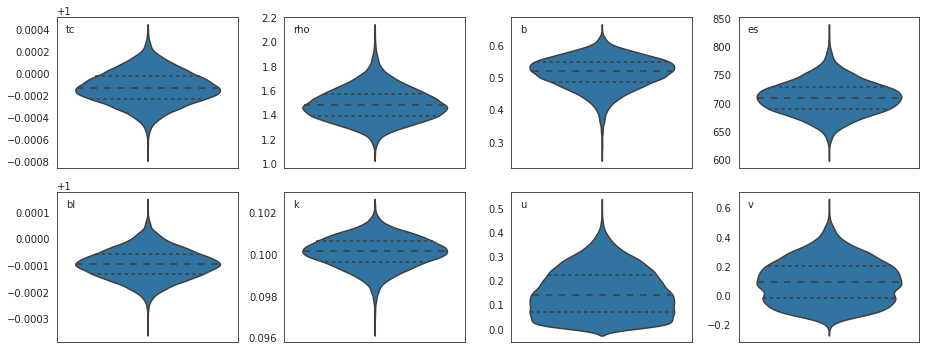

In [15]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5))
    pars = 'tc rho b es bl k u v'.split()
    [sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
    [axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
    setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

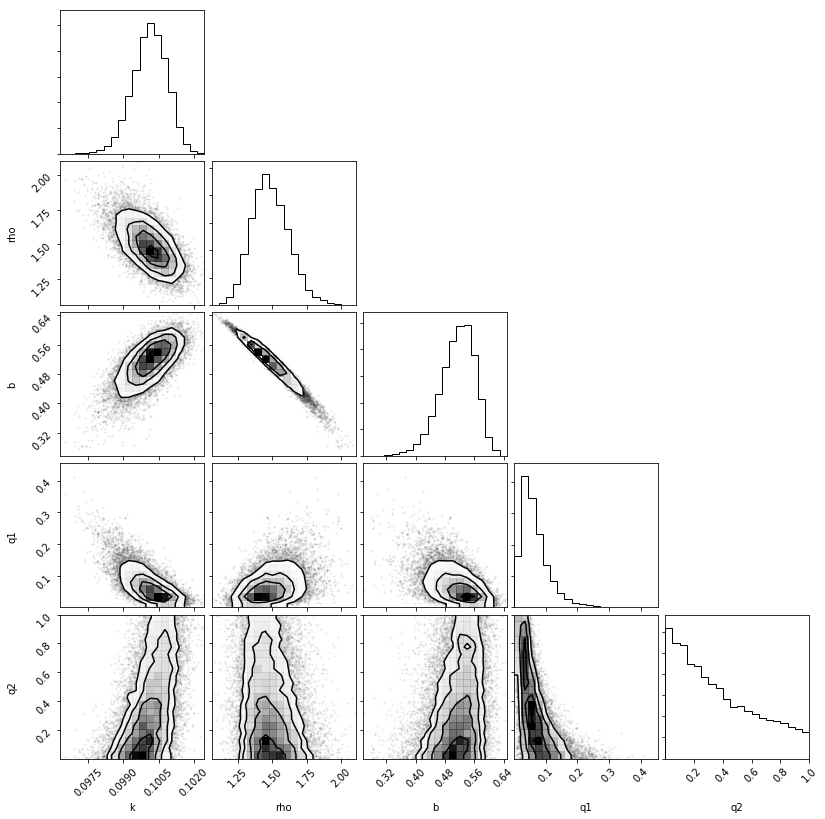

In [16]:
corner(df[['k', 'rho', 'b', 'q1', 'q2']]);

## Calculating the parameter estimates for all the filters

Ok, now, let's do the parameter estimation for all the filters. We wouldn't be doing separate per-filter parameter estimation in real life, since it's much better use of the data to do a simultaneous joint modelling of all the data together (this is something that will be shown in a later tutorial). This will take some time...

In [17]:
chains = []
npop, de_iter, mc_iter, mc_burn, thin = 100, 200, 1500, 1000, 10
for flux in fluxes:
    lpf = LPFunction(time, flux)
    lpf.optimize(de_iter, npop)
    lpf.sample(mc_burn, thin=thin)
    lpf.sample(mc_iter, thin=thin, reset=True)
    chains.append(lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]]))
chains = array(chains)

MCMC sampling: 100%|██████████| 1500/1500 [00:15<00:00, 95.03it/s]


In [18]:
ids = [list(repeat(filter_names,chains.shape[1])),8*list(range(chains.shape[1]))]
dft = pd.DataFrame(data = concatenate([chains[i,:,:] for i in range(chains.shape[0])]), 
                   index=ids, columns=lpf.ps.names)
dft['es'] *= 1e6
dft['k'] = sqrt(dft.k2)
dft['u'] = 2*sqrt(dft.q1)*dft.q2
dft['v'] = sqrt(dft.q1)*(1-2*dft.q2)
dft = dft.drop('k2', axis=1)
#dft.to_pickle(join('results','t1_df2.pkl'))

The dataframe creation can probably be done in a nicer way, but we don't need to bother with that. The results are now in a multi-index dataframe, from where we can easily get the per-filter point estimates. 

In [19]:
dft.loc['u'].describe()

,tc,pr,rho,b,q1,q2,es,bl,k,u,v
count,15000.0000,1.5000e+04,15000.0000,1.5000e+04,15000.0000,15000.0000,15000.0000,1.5000e+04,15000.0000,15000.0000,15000.0000
mean,1.0003,2.5000e+00,1.7542,3.8867e-01,0.6723,0.5880,752.4135,9.9996e-01,0.0977,0.9222,-0.1105
std,0.0002,9.8327e-08,0.2800,1.5103e-01,0.1856,0.1523,30.6114,5.7900e-05,0.0033,0.1164,0.2117
min,0.9996,2.5000e+00,0.9764,1.2905e-05,0.2488,0.1694,651.3661,9.9974e-01,0.0896,0.3356,-0.6162
25%,1.0002,2.5000e+00,1.5376,3.0082e-01,0.5199,0.4725,731.8596,9.9992e-01,0.0950,0.8448,-0.2644
50%,1.0003,2.5000e+00,1.7224,4.3035e-01,0.6726,0.5549,751.4490,9.9996e-01,0.0978,0.9226,-0.0911
75%,1.0004,2.5000e+00,1.9751,5.0224e-01,0.8306,0.6828,772.7079,1.0000e+00,0.1001,0.9994,0.0503
max,1.0009,2.5000e+00,2.4749,6.7992e-01,0.9999,0.9997,885.3034,1.0002e+00,0.1077,1.2650,0.6549


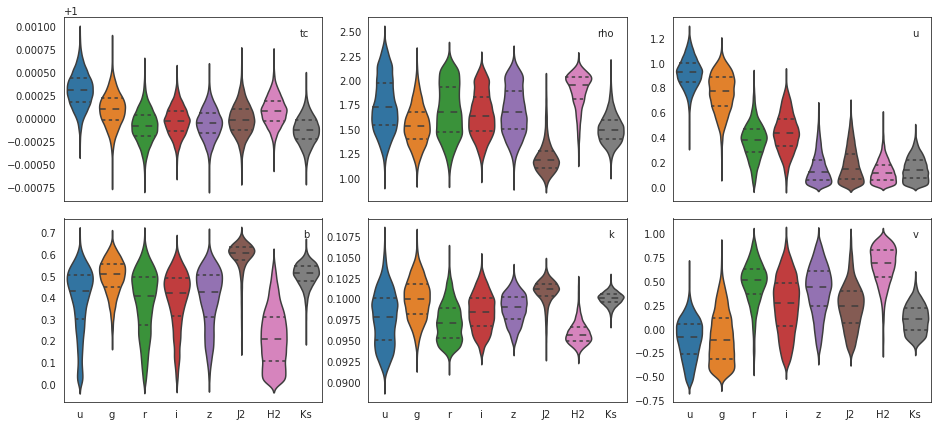

In [20]:
with sb.axes_style('white'):
    fig, axs = subplots(2,3, figsize=(13,6), sharex=True)
    pars = 'tc rho u b k v'.split()
    for i,p in enumerate(pars):
        sb.violinplot(data=dft[p].unstack().T, inner='quartile', scale='width', 
                      ax=axs.flat[i], order=filter_names)
        axs.flat[i].text(0.95,0.9, p, transform=axs.flat[i].transAxes, ha='right')
    fig.tight_layout()

As it is, the posterior distributions for different filters agree well with each other. However, the uncertainty in the radius ratio estimate decreases towards redder wavelengths. This is due to the reduced limb darkening, which allows us to estimate the true geometric radius ratio more accurately.

Finally, let's print the parameter estimates for each filter. We'll print the posterior medians with uncertainty estimates based on the central 68% posterior intervals. This matches the posterior mean and its 1-$\sigma$ uncertainty if the posterior is normal (which isn't really the case for many of the posteriors here). In real life, you'd want to report separate + and - uncertainties for the asymmetric posteriors, etc.

In [21]:
def ms(df,p,f):
    p = array(percentile(df[p][f], [50,16,84]))
    return p[0], abs(p[1:]-p[0]).mean()

def create_row(df,f,pars):
    return ('<tr><td>{:}</td>'.format(f)+
            ''.join(['<td>{:5.4f} &plusmn; {:5.4f}</td>'.format(*ms(dft,p,f)) for p in pars])+
            '</tr>')

def create_table(df):    
    pars = 'tc rho b k u v'.split()
    return ('<table style="width:100%"><th>Filter</th>'+
            ''.join(['<th>{:}</th>'.format(p) for p in pars])+
            ''.join([create_row(df,f,pars) for f in filter_names])+
            '</table>')

In [22]:
display(HTML(create_table(dft)))

u,1.0003 ± 0.0002,1.7224 ± 0.3080,0.4303 ± 0.1514,0.0978 ± 0.0036,0.9226 ± 0.1157,-0.0911 ± 0.2264
g,1.0001 ± 0.0002,1.5318 ± 0.2074,0.5061 ± 0.0815,0.1000 ± 0.0026,0.7736 ± 0.1631,-0.1171 ± 0.2952
r,0.9999 ± 0.0002,1.6777 ± 0.3052,0.4081 ± 0.1571,0.0970 ± 0.0024,0.3780 ± 0.1398,0.5081 ± 0.2058
i,1.0000 ± 0.0002,1.6349 ± 0.2525,0.4199 ± 0.1362,0.0984 ± 0.0024,0.4344 ± 0.1633,0.2664 ± 0.3313
z,0.9999 ± 0.0002,1.6708 ± 0.2770,0.4267 ± 0.1457,0.0990 ± 0.0019,0.1173 ± 0.1168,0.4344 ± 0.2758
J2,1.0000 ± 0.0002,1.1794 ± 0.1332,0.6068 ± 0.0473,0.1011 ± 0.0012,0.1445 ± 0.1433,0.2421 ± 0.2392
H2,1.0001 ± 0.0002,1.9466 ± 0.1668,0.2091 ± 0.1450,0.0957 ± 0.0012,0.1087 ± 0.0895,0.6933 ± 0.1973
Ks,0.9999 ± 0.0001,1.4920 ± 0.1439,0.5119 ± 0.0516,0.1001 ± 0.0008,0.1360 ± 0.1031,0.1037 ± 0.1635


---
<center>&copy; Hannu Parviainen 2014--2018</center>